# Using FPSL on Molecular Dynamics Data

In the following we will demonstrate how FPSL can be applied to data from molecular dynamics (MD) simulations.
We therefore use the MD data provided in the main paper, which can be downloaded from [NOMAD](https://nomad-lab.eu/prod/v1/staging/gui/dataset/id/ip6AiLTwSrySUXdNpggxyw?results.method.workflow_name=MolecularDynamics).

> Caution! The MD data is quite large (around 7.5 GB). Please make sure you have enough disk space available.

In the following, we will reproduce the toy model results from the main paper. Just for reference: Using an Nvidia 4060 GTX, running this notebook takes around 15 minutes.

## Imports

In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE = false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
import jax
import numpy as np
import prettypyplot as pplt
import jax_dataloader as jdl
from jax import numpy as jnp
from matplotlib import pyplot as plt
from matplotlib import colors

from fpsl import FPSL

# fix random seeds
key = jax.random.key(42)
jdl.manual_seed(42)
np.random.seed(42)


# ddpm training
n_epochs = 50
mlp_network = [64, 64, 64, 64, 64]
batch_size = 512
lrs = (1e-3, 5e-7)
sigma_min = 0.0005
sigma_max = 0.5
fourier_feat = 32


# setup plotting style
pplt.use_style(
    colors='paula_lime',
    figsize=(1, 1),
    cmap='plasma',
    true_black=True,
)
plt.rcParams['figure.dpi'] = 200
cnorm = colors.SymLogNorm(
    linthresh=0.1,
    linscale=1,
    vmin=-20,
    vmax=20,
    base=10,
)

Since we are training an MLP in this notebook it is important to use an GPU. The following will print how jax is initialized. If it shows `CPU`, but a GPU is available, you should install this package with `uv sync --extra cuda` or `pip install fpsl[cuda]`.

In [3]:
jax.devices()

[CudaDevice(id=0)]

# Load MD Data

In the following we will assume that you've downloaded the linked MD data and extracted the archive `raw_files`.

In [4]:
path_raw_files = 'path/to/raw_files'  # TODO: change this to your path
path_raw_files = '../../raw_files'  # for testing in repo

In [5]:
from fpsl.utils.md import load_trajs

directory = f'{path_raw_files}/y4PhzwtlQJecBZOgMbUdEw/view/depth_from_bilayer_core/'
file_basename = '{force:.1f}/job/solute_in_bilayer_production-{force:.1f}_pullx.xvg'
gro_basename = '{force:.1f}/job/solute_in_bilayer_equilibrate.gro'
ext_forces = np.arange(4, 12, 2)

Xs, ys, boxsizes, dt = load_trajs(
    directory=directory,
    ext_forces=ext_forces,
    pullx_basename=file_basename,
    gro_basename=gro_basename,
)

force: 4.00 with 5000001 frames and boxsize 10.1767 nm
force: 6.00 with 5000001 frames and boxsize 10.1767 nm
force: 8.00 with 5000001 frames and boxsize 10.1767 nm
force: 10.00 with 5000001 frames and boxsize 10.1767 nm


Now let us plot the steady states.

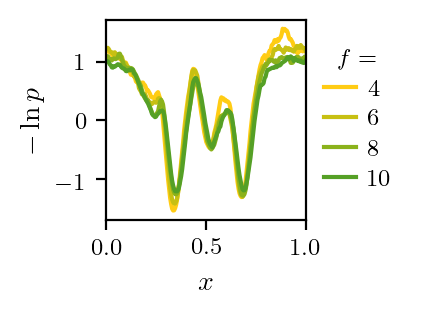

<Figure size 200x200 with 0 Axes>

In [6]:
fig, ax = plt.subplots()

# plot reference potential
bins = jnp.linspace(0, 1, 200)
for ext_force in ext_forces:
    hist, _ = np.histogram(
        Xs[ext_force],
        bins=bins,
        density=True,
    )

    ax.plot(
        0.5 * (bins[1:] + bins[:-1]),
        -np.log(hist),
        label=ext_force,
    )

ax.set_xlim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$-\ln p$')
ax.grid(False)
pplt.legend(outside='right', frameon=False, title='$f=$')
pplt.show()

## Training the Denoising Score Model

In the following we train for each external force a denoising score model (DSM) using the `fpsl` package. The training is done with the `train_dms` function, which takes the sampled data and the external forces as input. The training is done for a fixed number of epochs and the loss is plotted.

In [7]:
def train_dms(Xs, ys, key, sigma_min, ext_forces, stride=10):
    ddms = {}
    fig, ax = plt.subplots()
    for ext_force in [*ext_forces, None]:
        key, _ = jax.random.split(key)
        ddm = FPSL(
            mlp_network=mlp_network,
            key=key,
            n_epochs=n_epochs,
            batch_size=batch_size,
            sigma_max=sigma_max,
            sigma_min=sigma_min,
            fourier_features=fourier_feat,
            pbc_bins=0,
            warmup_steps=0,  # this is only needed for pbc_bins > 0
            symmetric=True,  # IMPORTANT!
        )

        if ext_force is None:  # train on all data
            X = jnp.concatenate([Xs[f][::stride] for f in ext_forces], axis=0)
            y = jnp.concatenate([ys[f][::stride] for f in ext_forces], axis=0)
        else:
            X = Xs[ext_force][::stride]
            y = ys[ext_force][::stride]

        loss = ddm.train(X, y=y, lrs=lrs)['train_loss']
        ddms[ext_force if ext_force is not None else 'all'] = ddm

        ax.plot(np.arange(1, n_epochs + 1), loss)

    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    pplt.show()

    return ddms, key

!!! Note
   By passing `symmetric=True` to the `FPSL` class, we ensure that the learned score function is periodic. This is important since the underlying potential is periodic and it improves the learning significantly!

To visualize the learned denoising score model, we plot the learned energy and score function as functions of the diffusion time and position.

In [8]:
def plot_score_energy(ddpm, axs=None):
    xs = jnp.linspace(0, 1, 50).reshape(-1, 1)
    ts = jnp.linspace(0, 1, 51)

    if axs is None:
        fig, axs = plt.subplots(
            1,
            2,
            gridspec_kw={'wspace': 2 / 3},
        )

    ax = axs[0]
    score = jnp.array([ddpm.score(xs, t).flatten() for t in ts])

    im = ax.pcolormesh(
        xs.flatten(),
        ts,
        score,
        norm=cnorm,
        cmap='Spectral',
    )
    pplt.colorbar(im, ax=ax, label=r'$\nabla \ln p$')
    ax.set_title('score')

    ax = axs[1]
    energy = jnp.array([ddpm.energy(xs, t).flatten() for t in ts])
    energy -= energy.min(axis=1, keepdims=True)
    p = np.exp(-energy)
    p /= p.sum(axis=1, keepdims=True) * (xs[1] - xs[0])

    im = ax.pcolormesh(
        xs.flatten(),
        ts,
        np.log(p),
        vmin=max(-5, np.log(p.min())),
    )
    pplt.colorbar(im, ax=ax, label=r'$\ln p$')
    ax.set_title('energy')

    for ax in axs:
        ax.grid(False)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$t$')

    if axs is None:
        pplt.label_outer(axs=axs)
        pplt.show()


def plot_score_energy_all(dms):
    fig, axs = plt.subplots(
        2,
        len(dms),
        gridspec_kw={'wspace': 2 / 3, 'hspace': 1 / 3},
    )

    for idx, (label, dm) in enumerate(dms.items()):
        ax_col = axs[:, idx]
        plot_score_energy(dm, axs=ax_col)

        pplt.text(
            0.5,
            1.4,
            f'$f={label}$' if label != 'all' else 'all',
            ax=ax_col[0],
            transform=ax_col[0].transAxes,
            size='x-large',
        )

    pplt.label_outer(axs=axs)
    pplt.show()

Finally, we plot the reference energy and the learned energy to visualize the learned free energy landscape.

In [9]:
def plot_final_potential(dms):
    fig, axs = plt.subplots(
        1,
        len(dms),
        gridspec_kw={'wspace': 0},
        figsize=(1, 1),
        sharey=True,
    )

    for idx, (label, dm) in enumerate(dms.items()):
        plt.sca(axs[idx])

        xs = np.linspace(0, 0.5 * boxsizes[ext_forces[0]], 200)
        energy = dm.energy(xs.reshape(-1, 1), t=0.0).flatten()
        energy = dm.energy(
            (xs / boxsizes[ext_forces[0]] + 0.5).reshape(-1, 1),
            t=0.0,
        ).flatten()
        p = np.exp(-energy)
        p /= p.sum() * (xs[1] - xs[0])
        axs[idx].plot(xs, -np.log(p))

        axs[idx].set_title(f'$f={label}$' if label != 'all' else 'all')
        axs[idx].grid(False)

    pplt.label_outer()
    pplt.show()

As noted in the paper, we can use different forces to train a single network. This is shown in the last column.

loss=1.125/1.125: 100%|██████████| 50/50 [06:21<00:00,  7.62s/it]


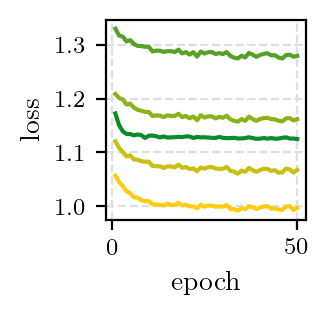

<Figure size 200x200 with 0 Axes>

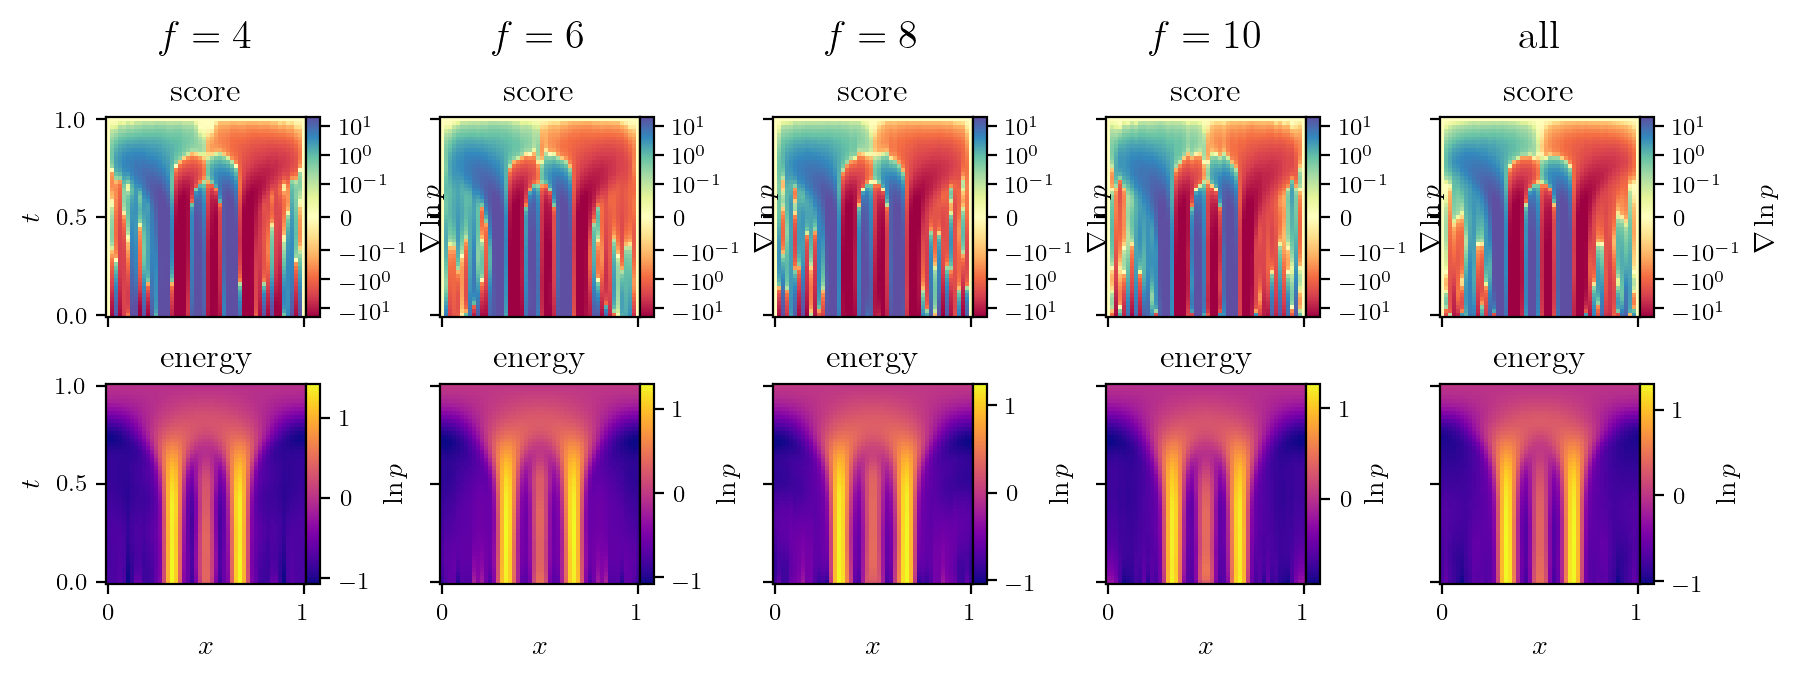

<Figure size 200x200 with 0 Axes>

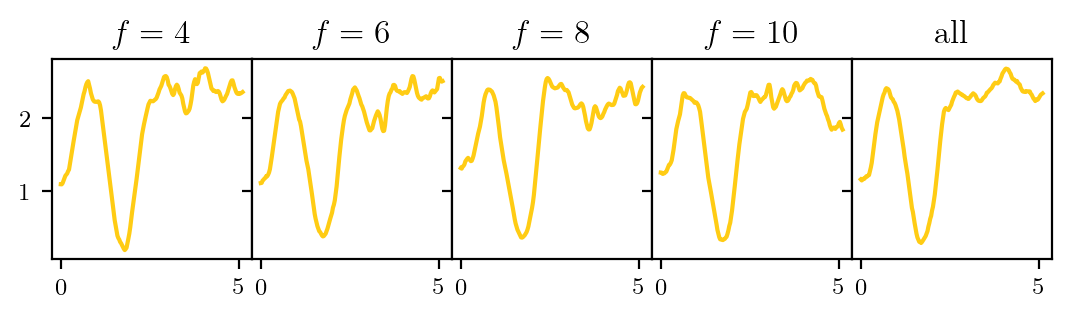

<Figure size 200x200 with 0 Axes>

In [10]:
dpdms, key = train_dms(Xs, ys, key, sigma_min, ext_forces)
plot_score_energy_all(dpdms)
plot_final_potential(dpdms)

We find that even with this short training time, all models were able to learn the correct free energy landscape. The learned energy profiles are very close to the reference energy profile. This shows that the FPSL framework is able to learn the free energy landscape from non-equilibrium steady state data. However, what should be noted is that for intermediate diffusion times, these models are not fully converged yet. But since, we are only interested in the equilibrium free energy profile, this is not a problem.